## Loading up packages

In [5]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [6]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
from magic_functions import process_frame

In [7]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/'
save_path2 = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TASEP-KS/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = 'Fmr1'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [8]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [9]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [10]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [11]:
# Load in the count positions data.
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

In [12]:
# Load in the elongation rates data.
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [13]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Calculate Smoothed Vector Arrays

OK, note too self: this time around I really should probably find a way to do this such that the stuff that is going to be filtered out gets filtered out. 

In [17]:
pre_load = False

In [19]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    mutant_list = []
    control_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            mutant_list.append(tr_m)
            control_list.append(tr_c)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [20]:
len(mutant_list)

4265

In [9]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       control_list),
                total=len(control_list)
            )
        )    
# Why do some of these (12430) take so much longer than others? 

100%|███████████████████████████████████████| 9181/9181 [02:19<00:00, 65.87it/s]


In [10]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       mutant_list),
                total=len(mutant_list)
            )
        )    

100%|███████████████████████████████████████| 9181/9181 [02:21<00:00, 64.72it/s]


## Determine KS statistic for all transcripts

In [11]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    len_list = []
    for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    len_list.clear()

In [10]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       data_control),
                total=len(data_control)
            )
        )    
# Why do some of these (12430) take so much longer than others? 

In [11]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
                total=len(data_mutant)
            )
        )    

## Determine KS statistic for all transcripts

In [12]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    gene_list = []
    tr_id = []
    len_list = []
    for tr_m, tr_c, transcript, index in zip(data_mutant, data_control, protein_coding, list(range(len(data_mutant)))):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = pool_mutant[index]
            smoothed_vec_c, cumul_c = pool_control[index]
            ks = max(abs(cumul_m - cumul_c))
            ks_list.append(ks)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    len_list.clear()

In [13]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

(0.0, 0.7)

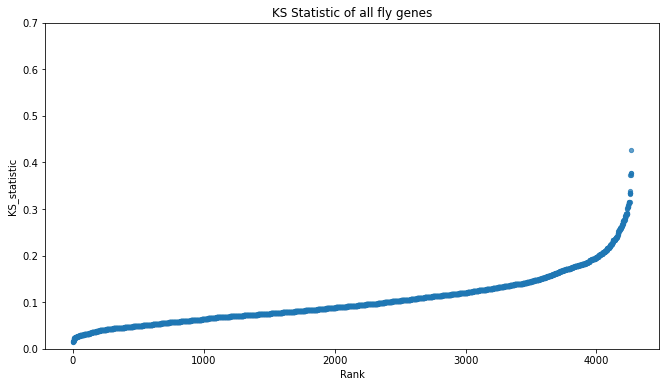

In [14]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=18, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS Statistic of all fly genes")
plt.ylim(0,0.7)

In [15]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [20]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.35)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [21]:
len(diff_dist)

4

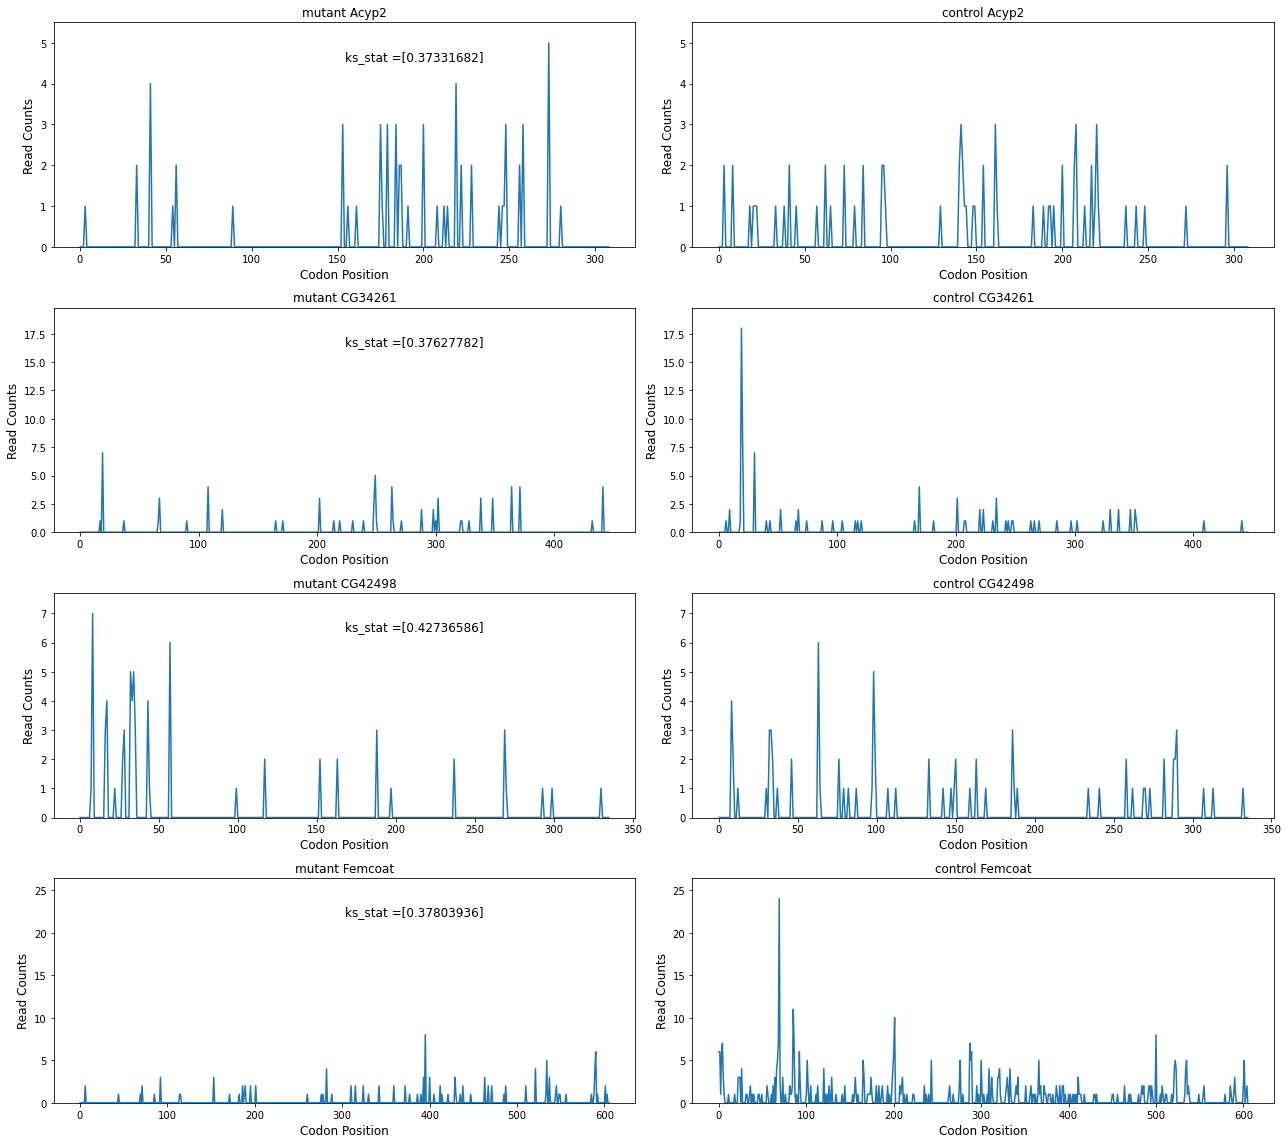

In [23]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (18,len(diff_dist)*4), fontsize = 12)

## Tasep-KS method

In [25]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    alt_p_list = []
    pbar_m_list = []
    pbar_c_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript in zip(data_mutant, data_control, elon_mutant, elon_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            alt_p_list.append(kat.alter_p(el_c, el_m))
            pbar_m_list.append(get_pbar_from_count(tr_m))
            pbar_c_list.append(get_pbar_from_count(tr_c))
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [26]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_alt_p = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       alt_p_list),
                total=len(alt_p_list)
            )
        )    

100%|███████████████████████████████████████| 1503/1503 [00:16<00:00, 91.87it/s]


In [27]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_m = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_m_list),
                total=len(pbar_m_list)
            )
        )    

100%|███████████████████████████████████████| 1503/1503 [00:16<00:00, 92.63it/s]


In [28]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_c = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_c_list),
                total=len(pbar_c_list)
            )
        )    

100%|███████████████████████████████████████| 1503/1503 [00:16<00:00, 91.71it/s]


In [29]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_m_list = []
    ks_c_list = []
    ks_diff_list = []
    for pbar_m, pbar_c, alt_p in zip(pool_pbar_m, pool_pbar_c, pool_alt_p):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            sm_m, cumul_m = pbar_m
            sm_c, cumul_c = pbar_c
            sm_p, cumul_p = alt_p
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            ks_m = max(abs(cumul_p - cumul_m))
            ks_c = max(abs(cumul_p - cumul_c))
            ks_diff = ks_c - ks_m
            ks_m_list.append(ks_m)
            ks_c_list.append(ks_c)
            ks_diff_list.append(ks_diff)
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, ks_m_list, ks_c_list, ks_diff_list)))
    df_t.columns = ["gene_ID","transcript_ID", "ks_mutant", "ks_control", "ks_diff"]
    df_t.to_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_m_list.clear()
    ks_c_list.clear()
    ks_diff_list.clear()

In [30]:
if pre_load == True:
    df_t = pd.read_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv")

In [ ]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_t["ks_diff"]))), sorted(df_t["ks_diff"]), s=18, alpha = 0.7)
plt.ylabel("KS Statistic")
plt.xlabel("Rank")
plt.title("KS difference (control - mutant)")

In [ ]:
df_t

In [ ]:
group = df_t[(df_t['ks_diff'] > 0.14)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_diff'].unique())

In [ ]:
len(diff_dist)

In [ ]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 12)

## Test Area

## Choose the gene of interest and smooth out the array.

In [ ]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('CG43103', 
                                           protein_coding, data_mutant, data_control)

In [ ]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [ ]:
sum(my_vec_control)

In [ ]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

In [ ]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

In [ ]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

In [ ]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [ ]:
ks = max(abs(cumul_m - cumul_c))
ks